In [501]:

import math 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import quaternion as Quaternion

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import decimate, resample_poly, resample
from scipy.interpolate import PchipInterpolator

from ahrs.filters.madgwick import Madgwick #ahrs library requires git clone, do not pip install


In [502]:

xl1 = pd.read_csv("imu_raw/xl1.csv")
xl2 = pd.read_csv("imu_raw/xl2.csv")
xl3 = pd.read_csv("imu_raw/xl3.csv")

mg1 = pd.read_csv("imu_raw/mg1.csv")
mg2 = pd.read_csv("imu_raw/mg2.csv")
gy = pd.read_csv("imu_raw/gy.csv")

#collect first 1000 intervals
xl1_group = xl1.groupby('interval')
first_10_xl = [group[['interval','timestamp','xl1.x','xl1.y','xl1.z']] for i, (name,group) in enumerate(xl1_group) if i < 1000]
xl_dat = pd.concat(first_10_xl).values

mg1_group = mg1.groupby('interval')
first_10_mg = [group[['interval','timestamp','mg1.x','mg1.y','mg1.z']] for i, (name,group) in enumerate(mg1_group) if i < 1000]
mg_dat = pd.concat(first_10_mg).values

gy_group = gy.groupby('interval')
first_10_gy = [group[['interval','timestamp','gy.x','gy.y','gy.z']] for i, (name,group) in enumerate(gy_group) if i < 1000]
gy_dat = pd.concat(first_10_gy).values

print(gy_dat.shape, mg_dat.shape, xl_dat.shape)

(933740, 5) (18427, 5) (930064, 5)


In [583]:
def gyr_offset_radians(gyr_dat, offset):
    """Put gy data in radians, remove measured error """
    gyr_off = gyr_dat - offset
    gyro_rad = gyr_off * ( np.pi / 180)
    
    return gyro_rad

def microtesla_to_nanotesla(value_µT):
    return value_µT * 1000

def clip_xl(xl_dat, clip):
    """
    XL sensors above certain thresholds are defective
    """
    xl_clipped = np.where(xl_dat > clip, clip, xl_dat)
    xl_clipped = np.where(xl_clipped < -1*clip, -1*clip, xl_clipped)
    return xl_clipped

def correct_data(dat):
    """ 
    Sorts sensor data by timestamp and removes duplicates
    Params: 
        dat: sensor data 
    """
    dat = np.array(dat).astype(float)
    sorted_dat = dat[dat[:,0].argsort()]

    _, unique_indices = np.unique(sorted_dat[:,0], return_index = True)
    processed_data = sorted_dat[unique_indices]
    return processed_data

def preprocess_imu(xl_raw, mag_raw, gyr_raw):
    """
    correct units, remove gyr offset
    Returns:
        data_matrix: (xl, mag, gyr)
    """
    xl_raw = clip_xl(xl_raw, 2)
    xl = xl_raw * 9.810665
    gyr_offset = np.array([.58, .42, -.3])   # Ahmed: how were these offset values chosen?
    gyr = gyr_offset_radians(gyr_raw, gyr_offset)
    mag = microtesla_to_nanotesla(mag_raw)
    return xl, mag, gyr

In [ ]:

def quatConjucate(q):
        w,x,y,z = q
        q_star = np.array([w,-x,-y,-z])
        return q_star
        
def quatProduct(q, p):
        q = np.array(q)
        p = np.array(p)
        w, x, y, z = list(q)

        q_matrix = np.array([
            [w, -x, -y, -z],
            [x, w, -z, y],
            [y, z, w, -x],
            [z, -y, x, w]
        ])
        return q_matrix @ p

# def inverse(q):
#         q_star = quatConjucate(q)
#         # norm = quatProduct(q, q_star) # Original norm computation
#         norm = np.linalg.norm(q) # Trying this instead
#         q_inverse = np.divide(q_star, norm)
#         return q_inverse

def inverse(q):
    q_star = quatConjucate(q)
    norm_squared = q @ q_star.T
    q_inverse = q_star / norm_squared
    return q_inverse

# def inverse(q):
#       q_star = quatConjucate(q)
#       norm_squared = np.linalg.norm(q_star)
#       norm = np.sqrt(norm_squared)
#       q_inverse = q_star / norm
#       return q_inverse
      

def rotate_vector(q, v, active=True):
        v = np.insert(np.array(v), 0, 0)  # convert to pure quaternion
        q_inv = inverse(q)

        if active: # object rotation
            q_product = quatProduct(q_inv, v)
            q_rot = quatProduct(q_product, q)
        else: # coordinate rotation
            q_product = quatProduct(q, v)
            q_rot = quatProduct(q_product, q_inv)

        return q_rot[1:]

def R(q_w, q_x, q_y, q_z):
    """
    Direction Cosine Matrix to rotate between two frames
    """
    # rotation_matrix = np.array([
    #     [q_w**2+q_x**2-q_y**2-q_z**2, 2*(q_x*q_y-q_w*q_z), 2*(q_x*q_z+q_w*q_y)],
    #     [2*(q_x*q_y+q_w*q_z), q_w**2-q_x**2+q_y**2-q_z**2, 2*(q_y*q_z-q_w*q_x)],
    #     [2*(q_x*q_z-q_w*q_y), 2*(q_w*q_x+q_y*q_z), q_w**2-q_x**2-q_y**2+q_z**2]
    # ])
            
    rotation_matrix = np.array([
        [1.0-2.0*(q_y**2+q_z**2), 2.0*(q_x*q_y-q_w*q_z), 2.0*(q_x*q_z+q_w*q_y)],
        [2.0*(q_x*q_y+q_w*q_z), 1.0-2.0*(q_x**2+q_z**2), 2.0*(q_y*q_z-q_w*q_x)],
        [2.0*(q_x*q_z-q_w*q_y), 2.0*(q_w*q_x+q_y*q_z), 1.0-2.0*(q_x**2+q_y**2)]
        ])
    return rotation_matrix

def rotate_to_ned(q, vec, madg):
    """
    rotates raw data by quaternion into global frame
    # """
    if (madg == True):
        rotation_matrix = R(*q) # Comment these two lines for Madgwick quaternion method.
        global_estimate = rotation_matrix.T @ vec  #eq. 10
    else:
        global_estimate = rotate_vector(q, vec, active=False) # Comment this out for other quaternion math

    return global_estimate


In [585]:
def interpolate_points(dat_ned, timestamps, odr):
    
    X_interpolate = np.arange(odr)
    interpolated_data = []

    for ax in range(3):
        spline = PchipInterpolator(timestamps, dat_ned[:,ax])
        interolated_points = spline(X_interpolate)

        interpolated_data.append(interolated_points)
    return np.array(interpolated_data).T

def time_align(xyz, sensor_odr, interval_odr, name):
    """ 
    Upsample data 2x interval odr(fourier signal), decimate data back down(lowpass filter), interpolate to desired interval odr, select current interval points
    """
    xyz_w = []
    len_w = []
    for i, itvl in enumerate(xyz):
        xyz_w.append(itvl)
        len_w.append(len(itvl))

    xyz_w = np.vstack(xyz_w)

    #resample/decimate/interpolate for entire window 
    xyz_r = resample(xyz_w, num=(sensor_odr*len(len_w))*2, axis=0) # set upsample 2x odr
    # print('xyz_r', xyz_r.shape)

    factor = xyz_r.shape[0]//((sensor_odr*len(len_w))) #set to downsample back to sensor odr
    xyz_d = decimate(xyz_r, q=factor, axis=0)
    # print('xyz_d', xyz_d.shape)
    
    new_points = interpolate_points(xyz_d, np.arange(xyz_d.shape[0]), interval_odr*3)
    current_points = new_points[interval_odr:interval_odr*2] #assumes window size 3 here 
    
    return np.array(current_points)

In [586]:
def imu_processing(xl, mg, gy, interval_odr, madg = True):
    """
    Main function, group data by intervals, build window of adjacent intervals for time alignment, this fixes errors on ends from resampling and decimating
    """

    sensor_odr = {"xl":1000, 'gy':1000, 'mg':20}
    sensor_dt = {'xl':.001, 'gy':.001, 'mg':.05}

    cols =['interval','timestamp','x', 'y', 'z']
    xl_df = pd.DataFrame(xl, columns=cols)
    mg_df = pd.DataFrame(mg, columns=cols)
    gy_df = pd.DataFrame(gy, columns=cols)

    xl_group = xl_df.groupby('interval')
    mg_group = mg_df.groupby('interval')
    gy_group = gy_df.groupby('interval')

    # print(list(xl_group))

    xl_global = []
    prev_q = [1,0,0,0]

    xl_w = [] #(3, n, 3) => window size 3, n points, xyz axis
    gy_w = []
    mg_w = []

    for (name1, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):

        xl_ = correct_data(xl_grp.drop(columns=['interval']).values)
        mg_ = correct_data(mg_grp.drop(columns=['interval']).values)
        gy_ = correct_data(gy_grp.drop(columns=['interval']).values)
        xl_p, mg_p, gy_p = preprocess_imu(xl_[:,1:], mg_[:,1:], gy_[:,1:])

        xl_w.append(xl_p)
        mg_w.append(mg_p)
        gy_w.append(gy_p)

        if len(xl_w) > 3: #build window  
            xl_w.pop(0)
            mg_w.pop(0)
            gy_w.pop(0)
    
        if len(xl_w) != 3:
            continue 
            
        xl_t = time_align(xl_w, 1000, interval_odr, 'xl')
        mg_t = time_align(mg_w, 20, interval_odr, 'mg')
        gy_t = time_align(gy_w, 1000, interval_odr, 'gy')

        #Madgwick model gives quaternion vectors that rotate xl vector from sensor to ned frame
        model = Madgwick(acc=xl_t, mag=mg_t, gyr=gy_t, frequency=interval_odr, q0 = prev_q)
        prev_q = model.Q[-1]

        for q,x in zip(model.Q, xl_t):
            mag = np.linalg.norm(x)
            norm_vec = x / mag
            ned_vec = rotate_to_ned(q, norm_vec, madg)
            ned_vec *= mag
            ned_vec[2] -= 9.810665 #in ned frame, assume z axis aligns with gravity, subtract it off
            xl_global.append(ned_vec)
        
    return xl_global


In [587]:
xl_ned = np.array(imu_processing(xl_dat, mg_dat, gy_dat, interval_odr=100))
print(np.array(xl_ned).shape)

(99800, 3)


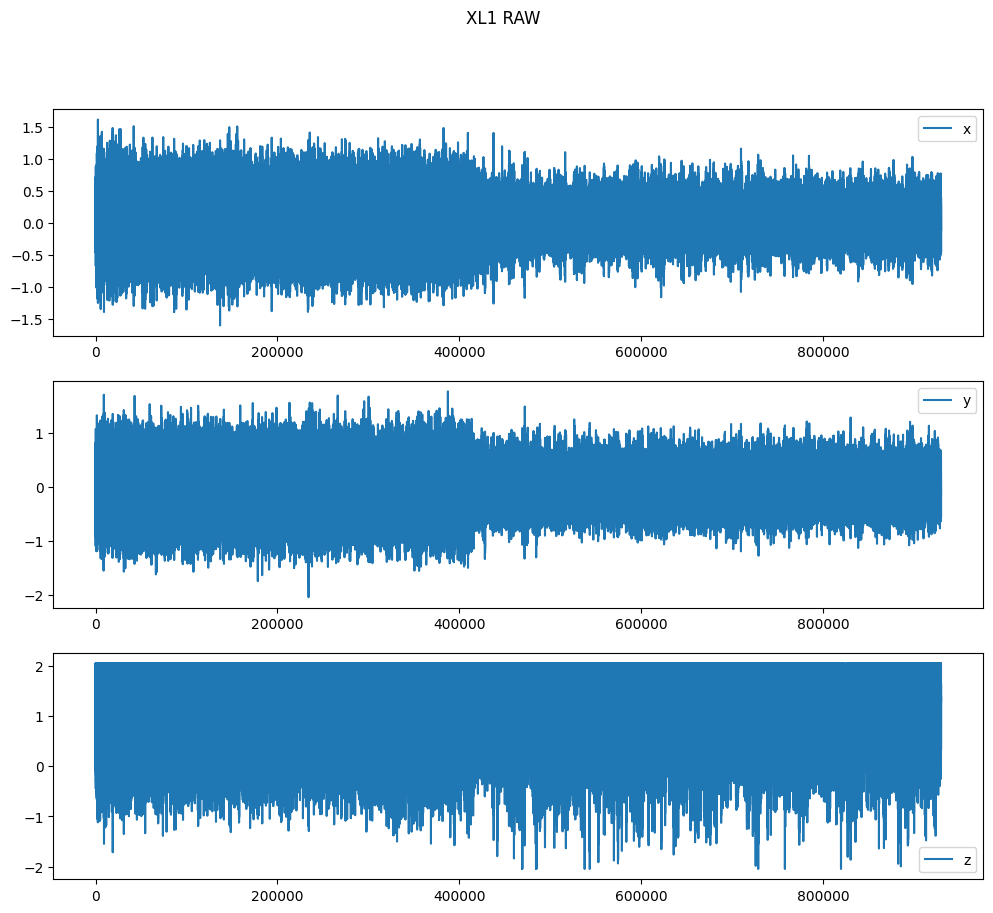

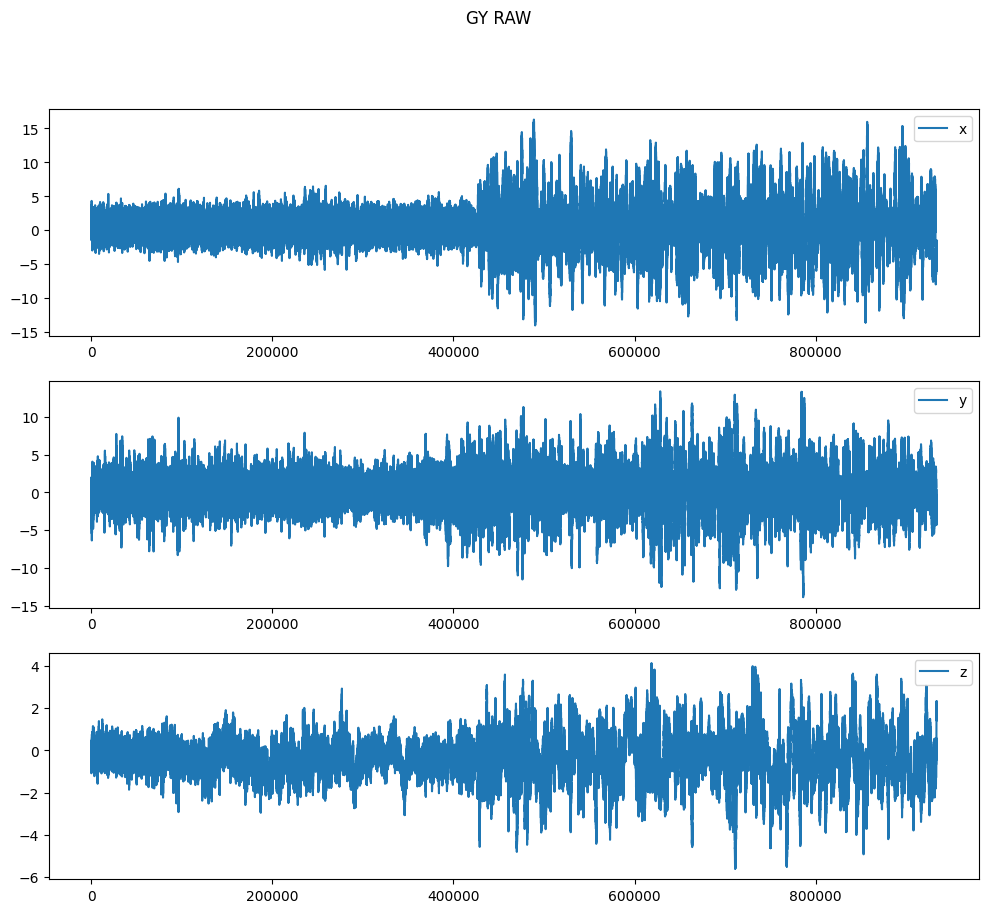

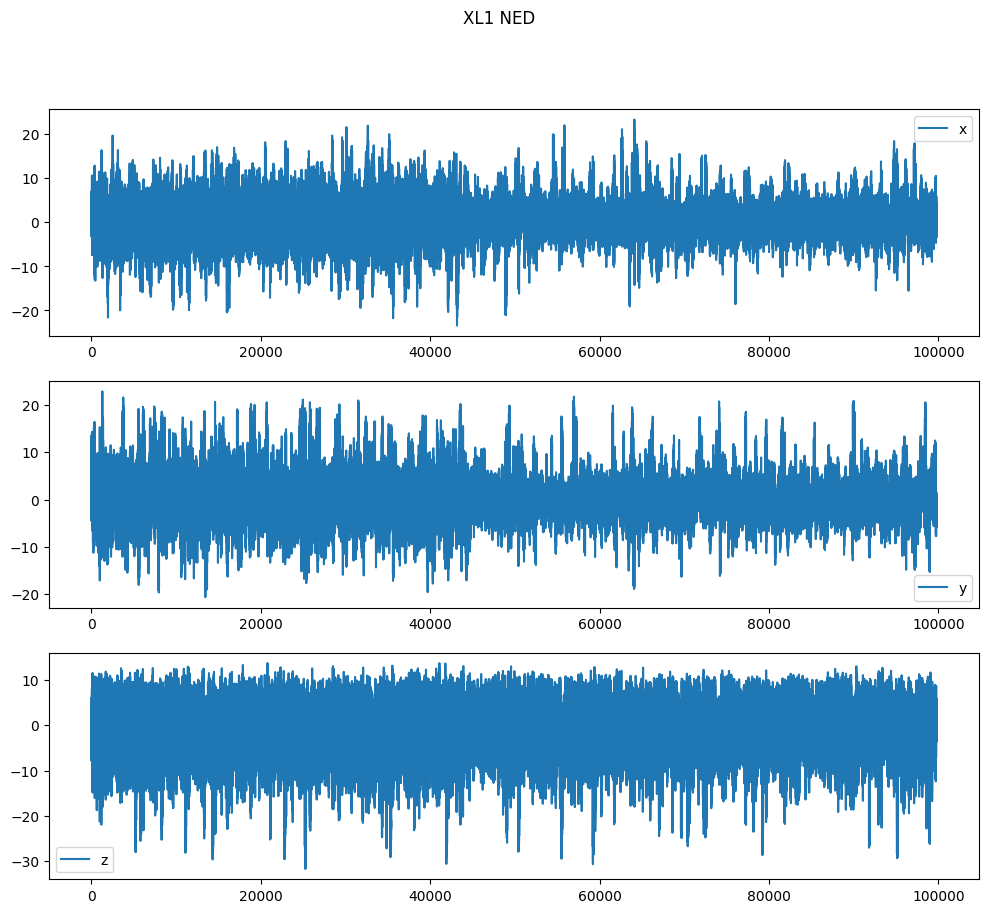

In [588]:
fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_dat[:,2], label='x') #(interval, timestamp, x,y,z)
axes[1].plot(xl_dat[:,3], label='y')
axes[2].plot(xl_dat[:,4], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 RAW')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(gy_dat[:,2], label='x')#(interval, timestamp, x,y,z)
axes[1].plot(gy_dat[:,3], label='y')
axes[2].plot(gy_dat[:,4], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('GY RAW')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_ned[:,0], label='x')
axes[1].plot(xl_ned[:,1], label='y')
axes[2].plot(xl_ned[:,2], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 NED')
plt.show()

(744064, 5)


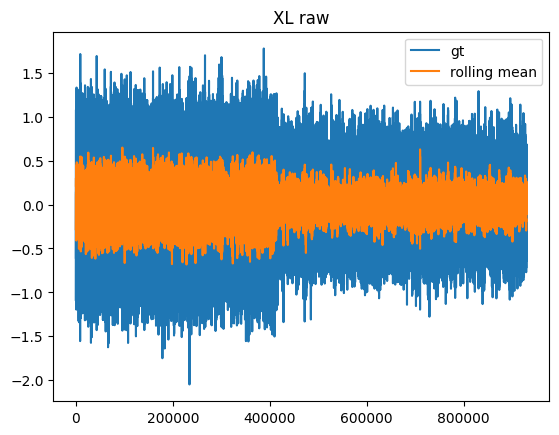

C:\Users\ChoudhryAhmed\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


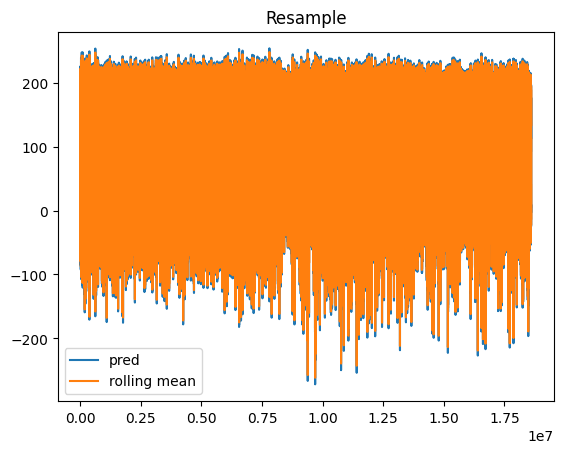

C:\Users\ChoudhryAhmed\AppData\Local\Temp\ipykernel_23092\2478026248.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


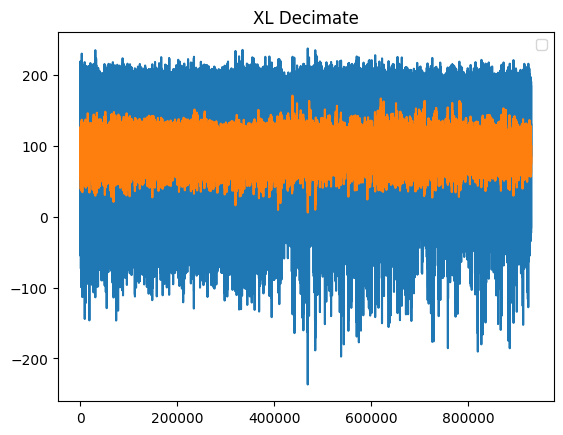

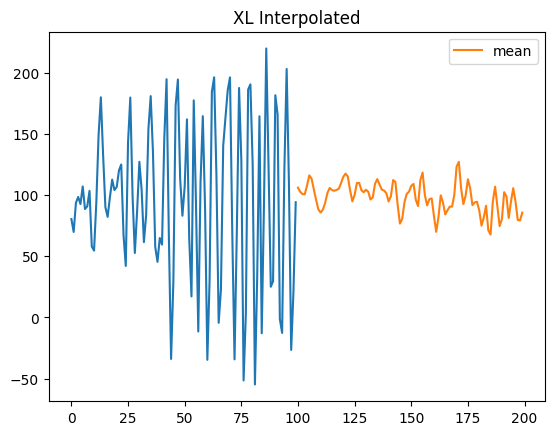

200
57188206878.88837
107045.74824164168
300
57188219128.96437
107045.74215791137
400
57188231356.11334
107045.73591941332
500
57188243951.04234
107045.73060210678
600
57188255389.81852
107045.72553984053
700
57188268481.01292
107045.7220542586
800
57188274489.871445
107045.7211795852
900
57188272489.81669
107045.71947028689
1000
57188274351.23973
107045.72085646144
1100
57188271639.8503
107045.71873003952
1200
57188272975.91583
107045.72013154645
1300
57188274104.67808
107045.72165257572
1400
57188270097.70902
107045.71766954733
1500
57188278020.631676
107045.72542647067
1600
57188269310.365036
107045.71723133951
1700
57188274406.389854
107045.72157269884
1800
57188274119.66316
107045.72125871095


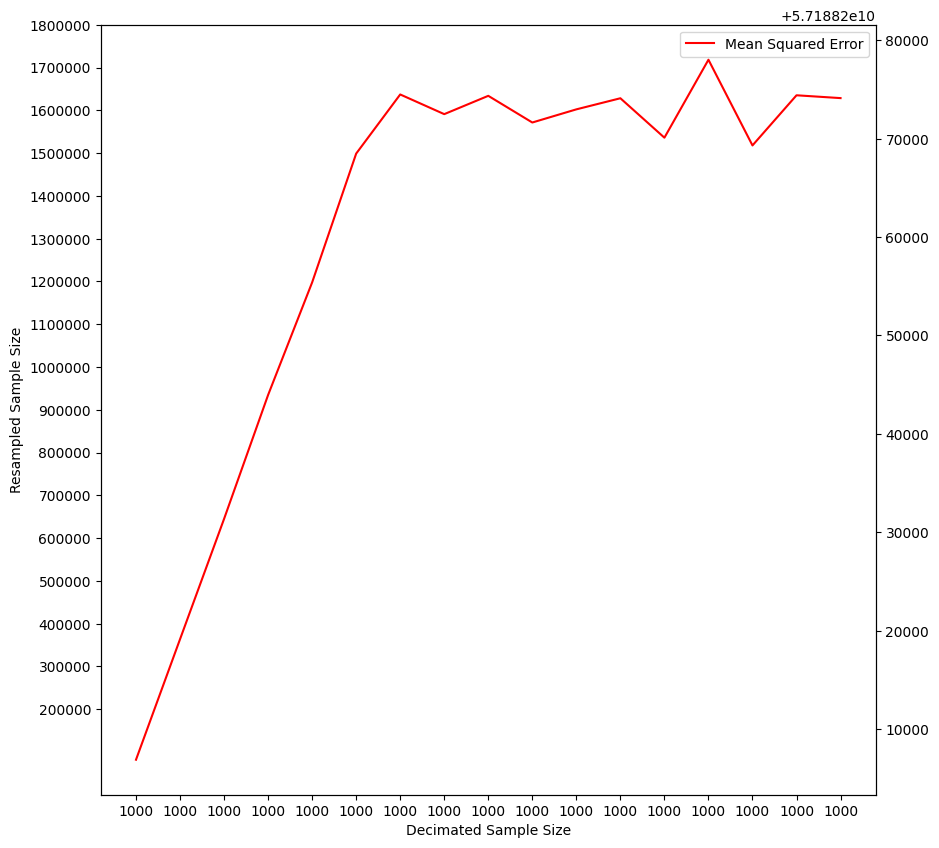

In [592]:
def keep_every_k_of_n(arr, k, n,):
    """
    Keeps `k` elements for every `n` elements from the array, simulate missing data 
    """
    kept = []
    i = 0
    while i < len(arr):
        kept.extend(arr[i:i+k])
        i += n
    return kept

xl_missing = keep_every_k_of_n(xl_dat[:1000,:], 400, 500)
print(np.array(xl_missing).shape)

#helper functions for experimenting with different parameters, plot rolling means  
xl_ = correct_data(xl_dat[:,1:])
xl_ = clip_xl(xl_, 2)
xl_ *= 9.8
xl_resample = resample(xl_[:,3]*9.8, num=18601280)
xl_decimate = decimate(xl_resample, q=20)

#raw data
rolling_mean = pd.Series(xl_dat[:,3]).rolling(window=10).mean()
plt.plot(xl_dat[:,3], label='gt')
plt.plot(rolling_mean, label='rolling mean')
plt.legend()
plt.title('XL raw')
plt.show()

#xl resample
rolling_mean = pd.Series(xl_resample).rolling(window=10).mean()
plt.plot(xl_resample, label='pred')
plt.plot(rolling_mean, label='rolling mean')
plt.title('Resample')
plt.legend()
plt.show()

#xl decimate
rolling_mean = pd.Series(xl_decimate).rolling(window=10).mean()
plt.plot(xl_decimate)
plt.plot(rolling_mean)
plt.title('XL Decimate')
plt.legend()
plt.show()

spline = PchipInterpolator(np.arange(xl_decimate.shape[0]), xl_decimate)
interpolated_points = spline(np.arange(0, 930064, 1))

rolling_mean = pd.Series(interpolated_points[:300]).rolling(window=10).mean()
plt.plot(interpolated_points[100:200])
plt.plot(rolling_mean[100:200], label='mean')
plt.title("XL Interpolated")
plt.legend()
plt.show()

# resample and decimate xl_missing
test_odr = 25
resample_list = np.arange(200000, 1860128, 100000)
decimate_list = np.arange(100000, 930064, 50000)
decimate_list_2 = np.repeat(1000, resample_list.shape[0])
mean_squared_list = []
decimate_2, resample_2 = np.meshgrid(decimate_list, resample_list)
for i in range(100000, 930064, 50000):
    xl_missing_r = resample(xl_missing, num = 2*i)
    factor = int((2*i)/1000)
    print(factor)
    xl_missing_d = decimate(xl_missing_r, q = factor, axis = 0)
    # spline = PchipInterpolator(np.arange(xl_missing_d.shape[0]), xl_missing_d)
    # xl_missing_interp = spline(np.arange(test_odr*3))

    # xl_new_interp, xl_new_dat = np.meshgrid()
    print(mean_squared_error(xl_missing_d, xl_dat[:1000,:]))
    print(mean_absolute_error(xl_missing_d, xl_dat[:1000,:]))

    mean_squared_list.append(mean_squared_error(xl_missing_d, xl_dat[:1000,:]))
    test_odr = 100

# ax = plt.scatter(decimate_list, resample_list, c = mean_squared_list, cmap = 'viridis', s = 100)
# plt.colorbar(ax, label='MSE')
# plt.grid(True)
# plt.xlabel("Decimated Sample Size")
# plt.ylabel("Resampled Sample Size")
# plt.title("MSE Variation with Resample and Decimation Sizes")
fig, ax1 = plt.subplots()
# ax1.plot(decimate_list, resample_list, label="Resample vs Decimate")
fig.set_figwidth(10)
fig.set_figheight(10)
ax_t = ax1.twinx()
ax_t.plot(decimate_list, mean_squared_list, label="Mean Squared Error", c="red")
ax1.set_xticks(decimate_list, labels=list(decimate_list_2))
ax1.set_yticks(resample_list, labels=list(resample_list))
ax1.set_xlabel("Decimated Sample Size")
ax1.set_ylabel("Resampled Sample Size")
plt.legend()
# plt.xticks(decimate_list, decimate_list)
plt.show()

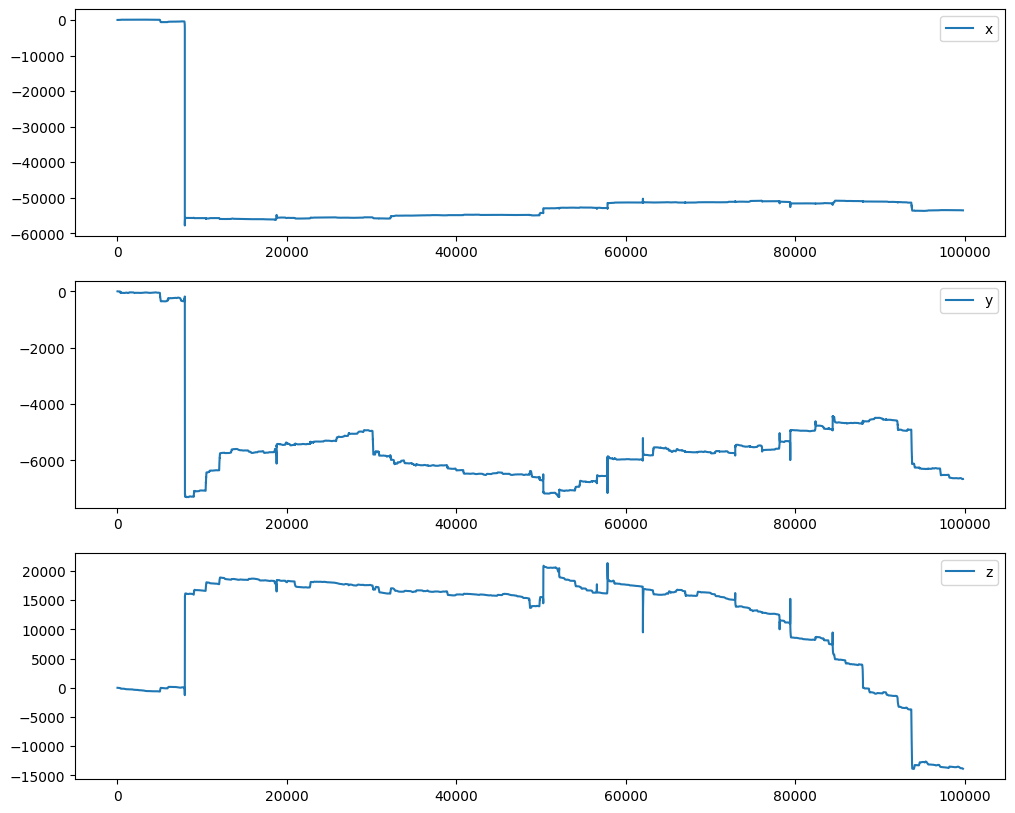

In [ ]:
def imu_dead_reckoning(xl_ned, dt):
    """Calculate position, velocity and bearing from xl/mag sensors in NED frame
    Args:
        xl_ned, mag_ned: sensor data in NED frame
        dt: timestamp delta
    Retuns:
        position, velocity, bearing 
    """
    velocity = np.zeros((len(xl_ned), 3))
    position = np.zeros((len(xl_ned), 3))

    for t in range(1, len(xl_ned)):
        velocity[t] = velocity[t-1] + (xl_ned[t-1] * dt)
        position[t] = position[t-1] + (velocity[t] * dt)
    
    fig, axes = plt.subplots(3, figsize=(12,10))
    axes[0].plot(velocity[:,0], label='x')
    axes[1].plot(velocity[:,1], label='y')
    axes[2].plot(velocity[:,2], label='z')

    for ax in axes:
        ax.legend()

    plt.show()

imu_dead_reckoning(xl_ned, 1/100) #dt is set to 1/100, I downsampled to 100 points per second 

(99800, 3)
(99800, 3)


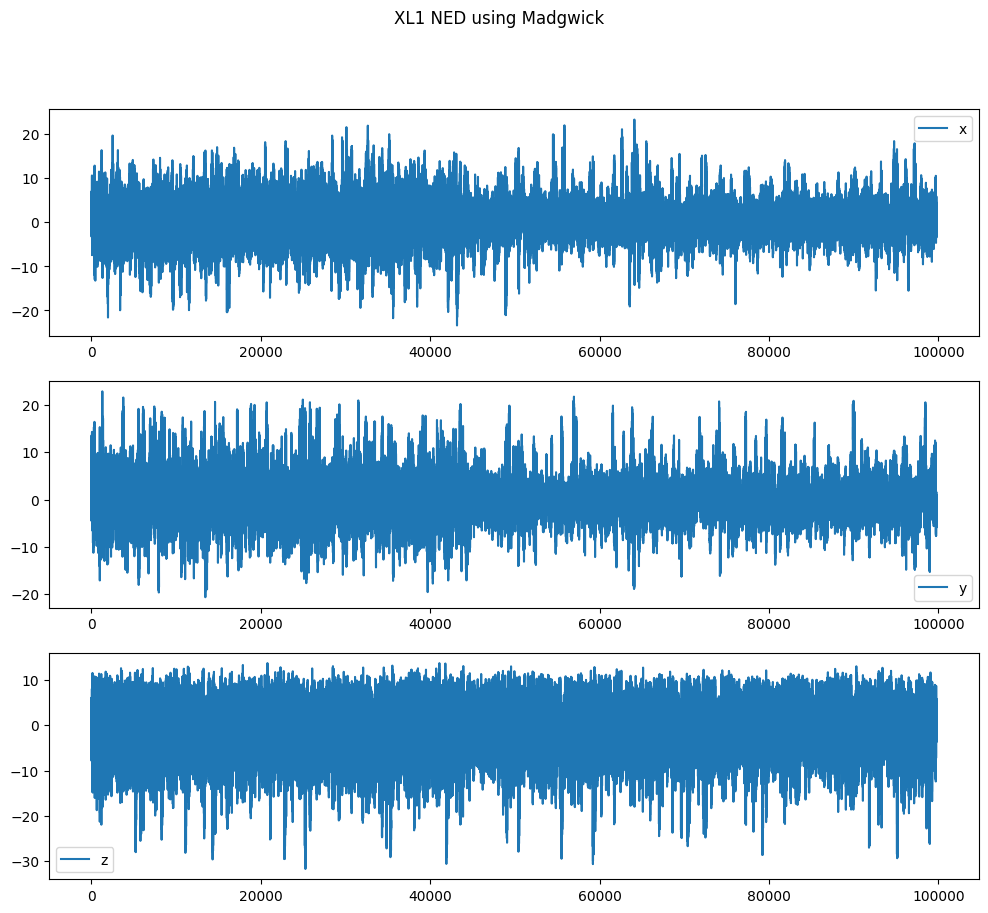

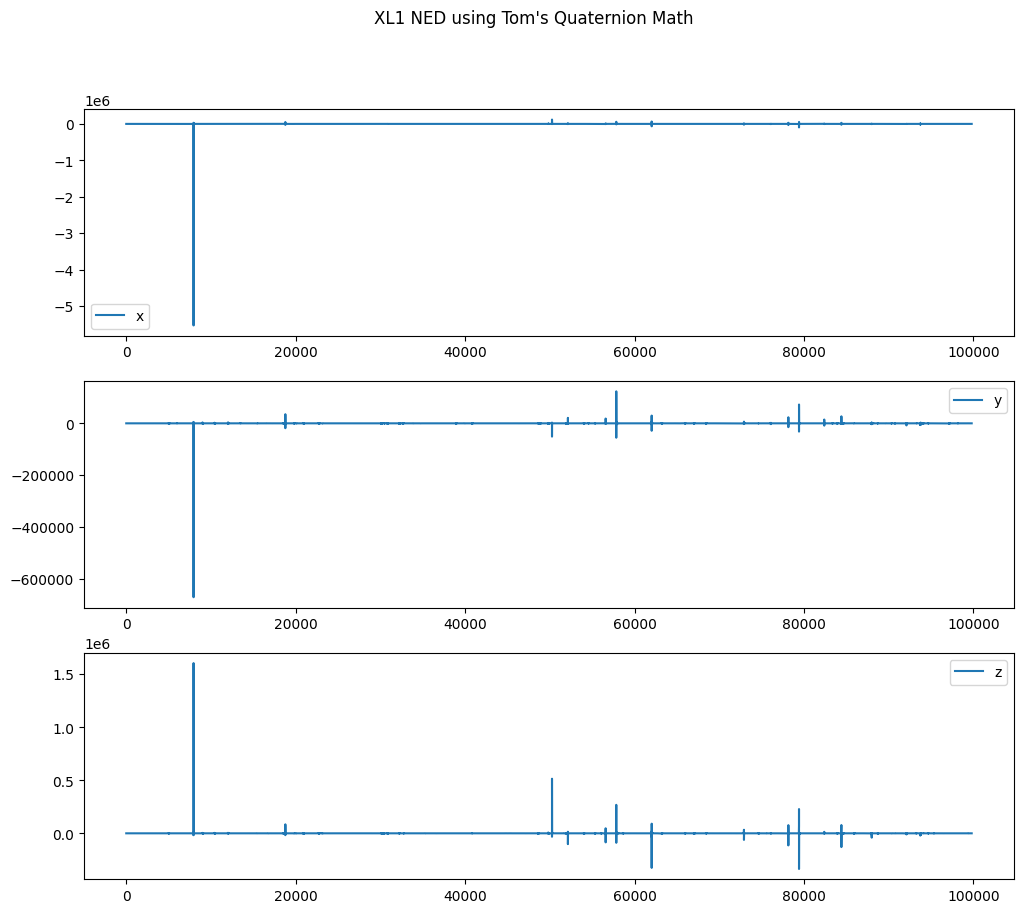

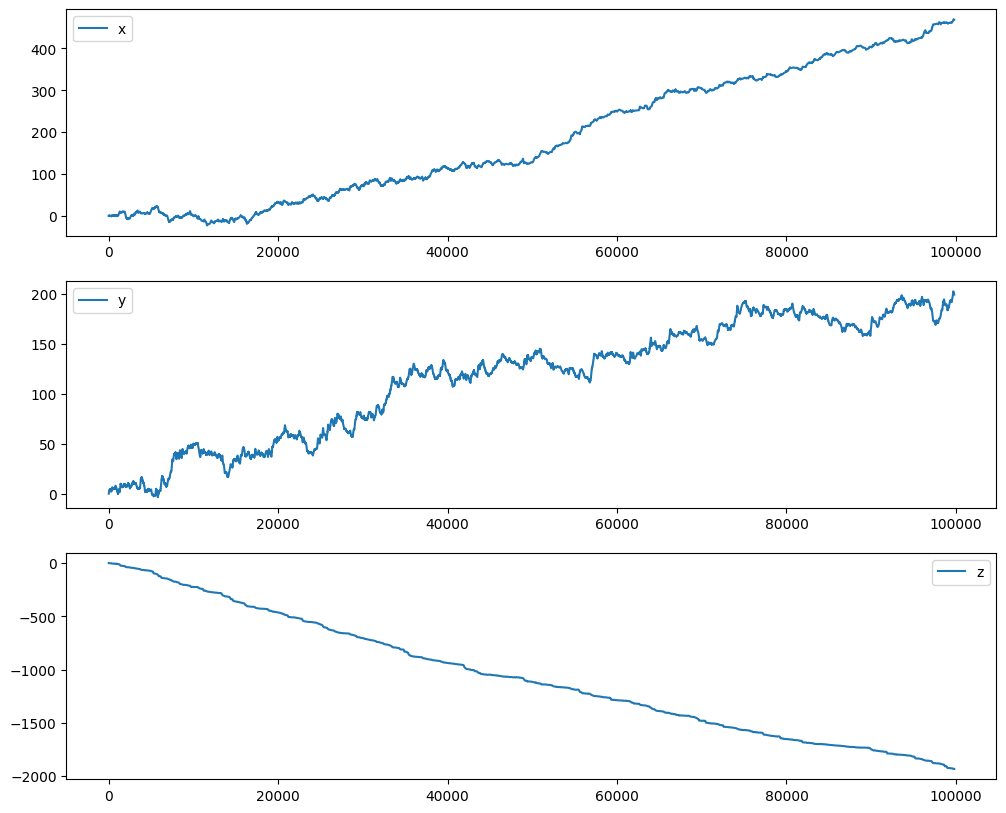

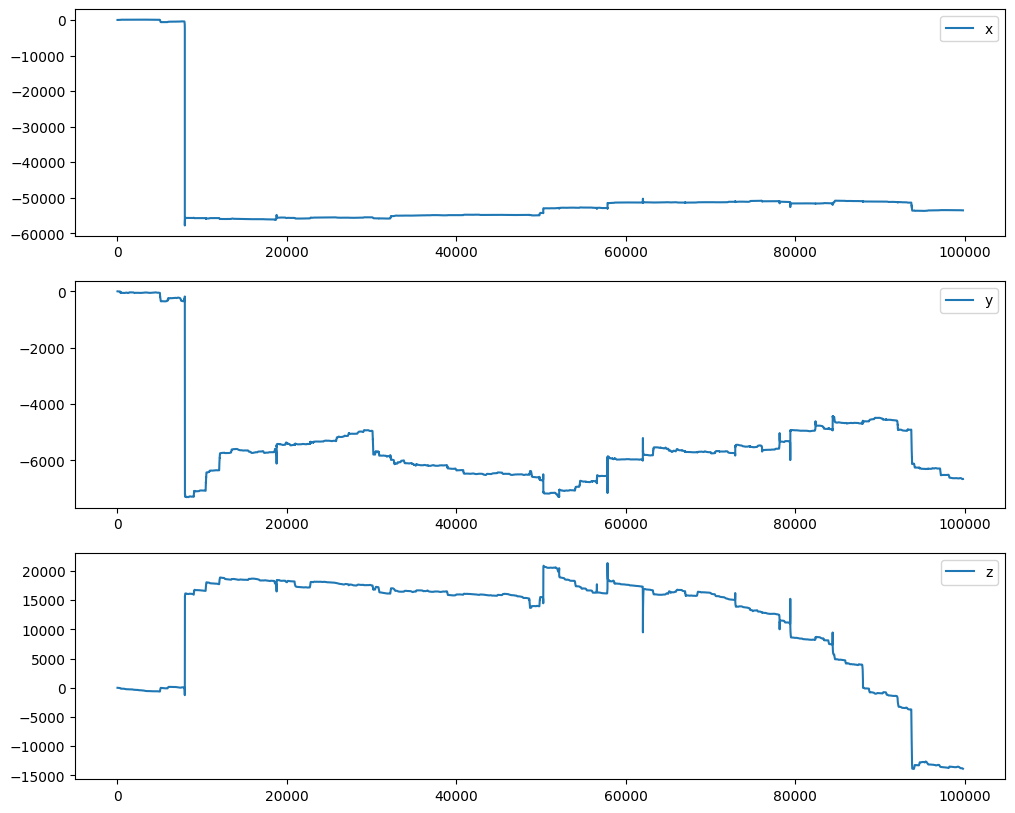

In [ ]:
# Comparing Madgwick and Quaternion Math

xl_ned_m = np.array(imu_processing(xl_dat, mg_dat, gy_dat, interval_odr=100, madg = True))
print(np.array(xl_ned).shape)

xl_ned_q = np.array(imu_processing(xl_dat, mg_dat, gy_dat, interval_odr=100, madg = False))
print(np.array(xl_ned).shape)

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_ned_m[:,0], label='x')
axes[1].plot(xl_ned_m[:,1], label='y')
axes[2].plot(xl_ned_m[:,2], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 NED using Madgwick')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_ned_q[:,0], label='x')
axes[1].plot(xl_ned_q[:,1], label='y')
axes[2].plot(xl_ned_q[:,2], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle("XL1 NED using Tom's Quaternion Math")
plt.show()


print("Velocity using Madgwick:")
imu_dead_reckoning(xl_ned_m, 1/100)

print("Velocity using Tom's Quaternion Math")
imu_dead_reckoning(xl_ned_q, 1/100)

print("Calculating Errors:")

(930064, 5)
(18427, 5)
(933740, 5)


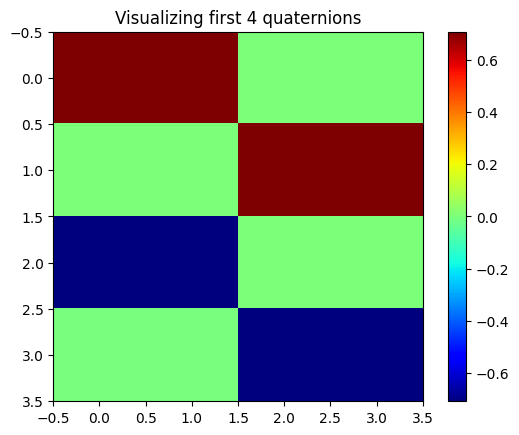

In [ ]:
# Visualizing first 4 quaternions using raw data
# I repeated the Madgwick operation to generate a heatmap using the first four vectors.
# This result will be compared using the time aligned and processed imu data for comparison.

print(xl_dat.shape)
print(mg_dat.shape)
print(gy_dat.shape)
new_xl = xl_dat[:18427,:3]
new_gy = gy_dat[:18427,:3]

new_quaternions = Madgwick(acc = new_xl, mqt = mg_dat[:,:3], gyr=new_gy)
quart_array = []
for q,x in zip(new_quaternions.Q, new_xl):
        mag = np.linalg.norm(x)
        norm_vec = x / mag
        ned_vec = rotate_to_ned(q, norm_vec)
        ned_vec = ned_vec*mag
        quart_array.append(q)

new_quart_array = np.array(quart_array)
new_quart_array = new_quart_array[:4,:]
plt.imshow(new_quart_array, cmap="jet")
plt.colorbar()
plt.title("Visualizing first 4 quaternions")
plt.show()


In [ ]:
print(ned_vec)
print(ned_vec.shape)

[-7.33995451e+06  2.43923388e+01 -4.61781059e+07]
(3,)


Text(0.5, 1.0, 'Resampling 32 data points of the sin function')

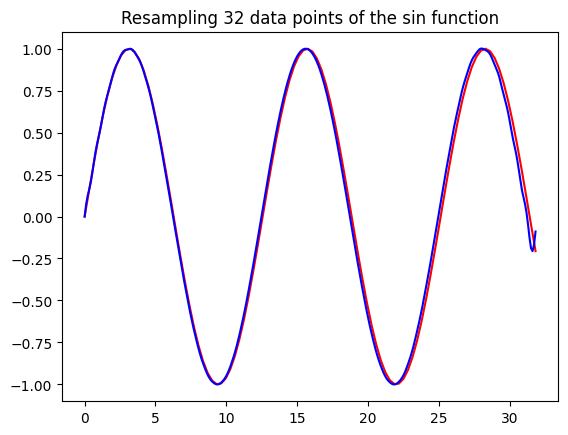

In [ ]:
# Visualizing the effects of resampling

test_interval = 100
sample_x_vals = np.linspace(0, (100/np.pi), 100)
sample_y_vals = np.sin((sample_x_vals/2))

data_r = resample(sample_y_vals, test_interval*3)
sample_x_r_vals = np.linspace(0, (100/np.pi), 300)

plt.plot(sample_x_vals, sample_y_vals, 'r')
plt.plot(sample_x_r_vals, data_r, 'b')

plt.title("Resampling 32 data points of the sin function")


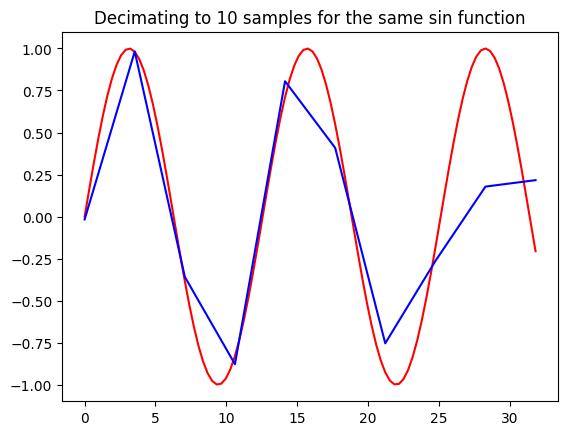

In [ ]:
# Visualizing the effects of decimating

data_d = decimate(data_r, q=test_interval//3, axis=0)

plt.plot(sample_x_vals, sample_y_vals, 'r')
plt.plot(np.linspace(0,(100/np.pi),10), data_d, 'b')

plt.title("Decimating to 10 samples for the same sin function")
plt.show()

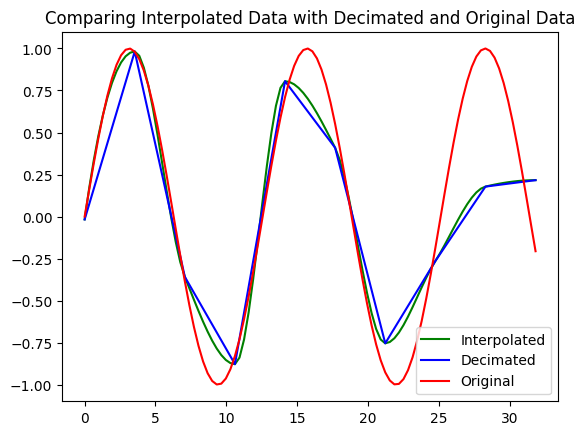

In [ ]:
# Interpolating on the decimated sample data, i.e data_d
spline = PchipInterpolator(np.linspace(0,(100/np.pi),10), data_d)
interp_data = spline(np.linspace(0,(100/np.pi),100))

plt.plot(np.linspace(0,(100/np.pi),100), interp_data, 'g', label="Interpolated")
plt.plot(np.linspace(0,(100/np.pi),10), data_d, 'b', label="Decimated")
plt.plot(sample_x_vals, sample_y_vals, 'r', label="Original")

plt.title("Comparing Interpolated Data with Decimated and Original Data")
plt.legend()
plt.show()



In [ ]:
# Storing the imu data inside a custom data class

import data

imu_data = data.Data("modified_xl1.csv")
print(imu_data)


 -------------------------------
modified_xl1.csv (930064x5)
Headers: 
  interval    timestamp    xl1.x    xl1.y    xl1.z  
Showing first 5/930064 rows.
0.0     46757786.0008     -0.39365234375     -0.60496875     1.1908125     
0.0     46757786.0018     0.27239453125     0.32833984375     0.9079453125     
0.0     46757786.0028     0.5186640625     0.7189375     1.0464765625     
0.0     46757786.0038     0.5548671875     0.10870703125     1.96628125     
0.0     46757786.0048     0.09496484375     0.002421875     0.63576953125     



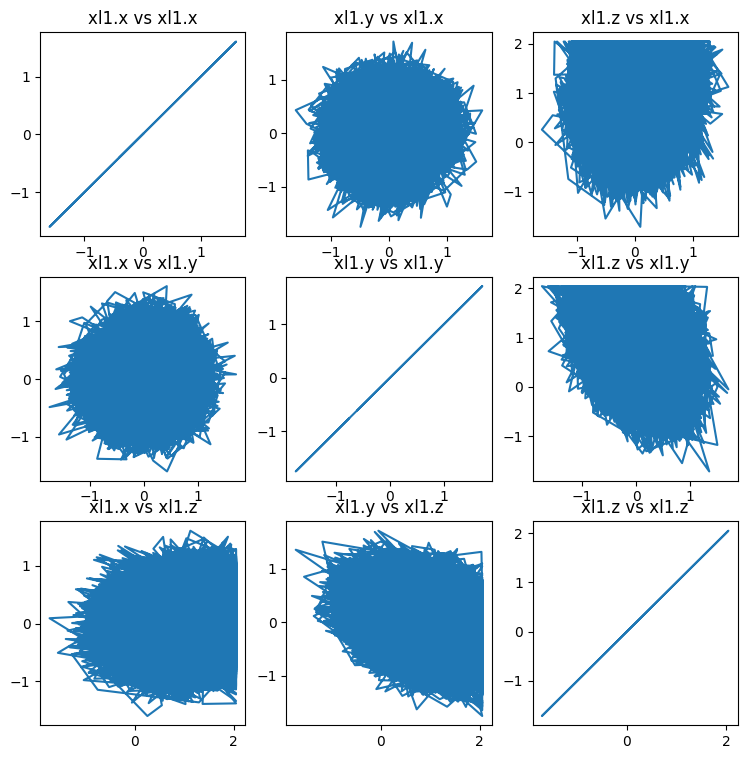

In [ ]:
header_list = ["xl1.x", "xl1.y", "xl1.z"]
imu_copy = imu_data.select_data(headers = header_list, rows = list(np.arange(0, 200000, 1)))
fig, axes = plt.subplots(3,3)
fig.set_figheight(9)
fig.set_figwidth(9)

for i in range(3):
    for j in range(3):
        axes[i][j].plot(imu_copy[:,i], imu_copy[:,j])
        axes[i][j].set_title(header_list[j] + " vs " + header_list[i])
